In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix, roc_auc_score

In [20]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass
password = getpass.getpass()

········


In [3]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

In [4]:
query = 'select * from sakila.rentals_may_june'
data = pd.read_sql_query(query, engine)
data.head()

,film_id,title,release_year,rental_rate,length,rating,category,times_rented_may,times_rented_jun
0,1,ACADEMY DINOSAUR,2006,0.99,86,PG,6,2,3
1,2,ACE GOLDFINGER,2006,4.99,48,G,11,0,0
2,3,ADAPTATION HOLES,2006,2.99,50,NC-17,6,1,1
3,4,AFFAIR PREJUDICE,2006,2.99,117,G,11,2,2
4,5,AFRICAN EGG,2006,2.99,130,G,8,1,2


In [5]:
# checking data for null values and datatype of columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   film_id           1000 non-null   int64  
 1   title             1000 non-null   object 
 2   release_year      1000 non-null   int64  
 3   rental_rate       1000 non-null   float64
 4   length            1000 non-null   int64  
 5   rating            1000 non-null   object 
 6   category          1000 non-null   int64  
 7   times_rented_may  1000 non-null   int64  
 8   times_rented_jun  1000 non-null   int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 70.4+ KB


In [6]:
# checking for duplicates on film_ids
data['film_id'].duplicated().sum()

0

In [7]:
# checking numeric values
data.describe()

,film_id,release_year,rental_rate,length,category,times_rented_may,times_rented_jun
count,1000.000000,1000.0,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,500.500000,2006.0,2.980000,115.272000,8.47800,1.156000,2.311000
std,288.819436,0.0,1.646393,40.426332,4.61029,1.053933,1.439566
min,1.000000,2006.0,0.990000,46.000000,1.00000,0.000000,0.000000
25%,250.750000,2006.0,0.990000,80.000000,5.00000,0.000000,1.000000
50%,500.500000,2006.0,2.990000,114.000000,8.00000,1.000000,2.000000
75%,750.250000,2006.0,4.990000,149.250000,13.00000,2.000000,3.000000
max,1000.000000,2006.0,4.990000,185.000000,16.00000,5.000000,7.000000


#### release year is always 2006 --> not useful

In [9]:
# checking correlation of numerical data
numerical = data.select_dtypes('number').drop('category', axis=1)

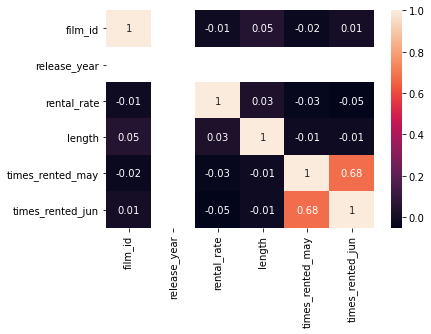

In [10]:
sns.heatmap(round(numerical.corr(),2), annot=True, annot_kws={"size": 10})
plt.show()

#### no relevant correlation between features - but, also almost no correlation with target (except rental times may/june are correlated)

In [11]:
# checking categorical data
categorical = data[['category', 'rating']]

In [12]:
data.category.value_counts()

15    74
9     73
8     69
6     68
2     66
1     64
13    63
7     62
10    61
14    61
3     60
5     58
4     57
16    57
11    56
12    51
Name: category, dtype: int64

In [13]:
data.rating.value_counts()

PG-13    223
NC-17    210
R        195
PG       194
G        178
Name: rating, dtype: int64

In [14]:
# generate binary values using get_dummies
categorical = pd.get_dummies(data=categorical, columns=categorical.columns, drop_first=True)
data=data.join(categorical)
data

,film_id,title,release_year,rental_rate,length,rating,category,times_rented_may,times_rented_jun,category_2,...,category_11,category_12,category_13,category_14,category_15,category_16,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,1,ACADEMY DINOSAUR,2006,0.99,86,PG,6,2,3,0,...,0,0,0,0,0,0,0,1,0,0
1,2,ACE GOLDFINGER,2006,4.99,48,G,11,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,3,ADAPTATION HOLES,2006,2.99,50,NC-17,6,1,1,0,...,0,0,0,0,0,0,1,0,0,0
3,4,AFFAIR PREJUDICE,2006,2.99,117,G,11,2,2,0,...,1,0,0,0,0,0,0,0,0,0
4,5,AFRICAN EGG,2006,2.99,130,G,8,1,2,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,YOUNG LANGUAGE,2006,0.99,183,G,6,0,1,0,...,0,0,0,0,0,0,0,0,0,0
996,997,YOUTH KICK,2006,0.99,179,NC-17,12,0,1,0,...,0,1,0,0,0,0,1,0,0,0
997,998,ZHIVAGO CORE,2006,0.99,105,NC-17,11,1,2,0,...,1,0,0,0,0,0,1,0,0,0
998,999,ZOOLANDER FICTION,2006,2.99,101,R,3,1,2,0,...,0,0,0,0,0,0,0,0,0,1


In [28]:
# defining target - rented/not rented in june
def recode_target(x):
    if x == 0:
        return '0'
    else:
        return '1'

In [29]:
data['target_rented'] = list(map(recode_target, data['times_rented_jun']))

In [31]:
#crosschecking the recoding
pd.crosstab(data['times_rented_jun'], data['target_rented'])

target_rented,0,1
times_rented_jun,,
0,100,0
1,0,206
2,0,275
3,0,222
4,0,118
5,0,58
6,0,20
7,0,1


In [32]:
data.target_rented.value_counts()

1    900
0    100
Name: target_rented, dtype: int64

In [23]:
data.columns

Index(['film_id', 'title', 'release_year', 'rental_rate', 'length', 'rating',
       'category', 'times_rented_may', 'times_rented_jun', 'category_2',
       'category_3', 'category_4', 'category_5', 'category_6', 'category_7',
       'category_8', 'category_9', 'category_10', 'category_11', 'category_12',
       'category_13', 'category_14', 'category_15', 'category_16',
       'rating_NC-17', 'rating_PG', 'rating_PG-13', 'rating_R', 'target'],
      dtype='object')

### Logistic Regression

In [33]:
# Define target and Features
y = data.target_rented
X = data[['rental_rate', 'length', 'times_rented_may', 'category_2',
       'category_3', 'category_4', 'category_5', 'category_6', 'category_7',
       'category_8', 'category_9', 'category_10', 'category_11', 'category_12',
       'category_13', 'category_14', 'category_15', 'category_16',
       'rating_NC-17', 'rating_PG', 'rating_PG-13', 'rating_R']]

C:\Users\Anne_2\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Anne_2\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


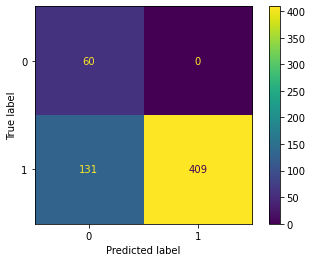

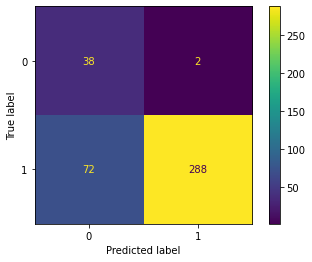

In [34]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.40, random_state=100, stratify = y)

# Scale data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Logstic regression
log_reg = LogisticRegression(class_weight='balanced')
log_reg.fit(X_train, y_train)

y_train_predict = log_reg.predict(X_train)
y_test_predict = log_reg.predict(X_test)

# confusion matrix
plot_confusion_matrix(log_reg, X_train, y_train)
plot_confusion_matrix(log_reg, X_test, y_test)
plt.show()

In [35]:
# Model validation
print(classification_report(y_train, y_train_predict))
print(classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.31      1.00      0.48        60
           1       1.00      0.76      0.86       540

    accuracy                           0.78       600
   macro avg       0.66      0.88      0.67       600
weighted avg       0.93      0.78      0.82       600

              precision    recall  f1-score   support

           0       0.35      0.95      0.51        40
           1       0.99      0.80      0.89       360

    accuracy                           0.81       400
   macro avg       0.67      0.88      0.70       400
weighted avg       0.93      0.81      0.85       400



In [36]:
# Roc Auc score
print(roc_auc_score(y_train, y_train_predict))
print(roc_auc_score(y_test, y_test_predict))

0.8787037037037038
0.875


## Running logistic regression again but with rentals in may as target

In [37]:
data['target_may'] = list(map(recode_target, data['times_rented_may']))

In [39]:
#crosschecking the recoding
pd.crosstab(data['times_rented_may'], data['target_may'])

target_may,0,1
times_rented_may,,
0,314,0
1,0,355
2,0,225
3,0,76
4,0,27
5,0,3


In [40]:
data.target_may.value_counts()

1    686
0    314
Name: target_may, dtype: int64

#### target is still imbalanced but not as much as for june data

In [41]:
# Define target and Features
y = data.target_may
X = data[['rental_rate', 'length', 'category_2',
       'category_3', 'category_4', 'category_5', 'category_6', 'category_7',
       'category_8', 'category_9', 'category_10', 'category_11', 'category_12',
       'category_13', 'category_14', 'category_15', 'category_16',
       'rating_NC-17', 'rating_PG', 'rating_PG-13', 'rating_R']]
# features don't include previous rentals anymore, because there is no data for April 2005

C:\Users\Anne_2\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Anne_2\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


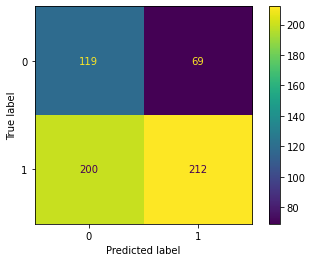

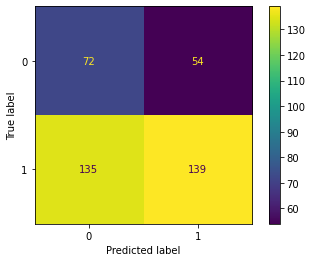

In [42]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.40, random_state=100, stratify = y)

# Scale data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Logstic regression
log_reg = LogisticRegression(class_weight='balanced')
log_reg.fit(X_train, y_train)

y_train_predict = log_reg.predict(X_train)
y_test_predict = log_reg.predict(X_test)

# confusion matrix
plot_confusion_matrix(log_reg, X_train, y_train)
plot_confusion_matrix(log_reg, X_test, y_test)
plt.show()

In [43]:
# Model validation
print(classification_report(y_train, y_train_predict))
print(classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.37      0.63      0.47       188
           1       0.75      0.51      0.61       412

    accuracy                           0.55       600
   macro avg       0.56      0.57      0.54       600
weighted avg       0.63      0.55      0.57       600

              precision    recall  f1-score   support

           0       0.35      0.57      0.43       126
           1       0.72      0.51      0.60       274

    accuracy                           0.53       400
   macro avg       0.53      0.54      0.51       400
weighted avg       0.60      0.53      0.54       400



### --> model is performing much worse, rental of previous month seems to be an important feature